### Monte Carlo Simulation for GoldenFlashes Andromeda

In [86]:
# We import these lines for debugging purposes, only works on Jupyter Notebook
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
# Import Necessary Dependencies
import datetime
from rocketpy import Environment, Flight, Function, MonteCarlo, Rocket, SolidMotor
from rocketpy.stochastic import (
    StochasticEnvironment,
    StochasticFlight,
    StochasticNoseCone,
    StochasticParachute,
    StochasticRailButtons,
    StochasticRocket,
    StochasticSolidMotor,
    StochasticTail,
    StochasticTrapezoidalFins,
)

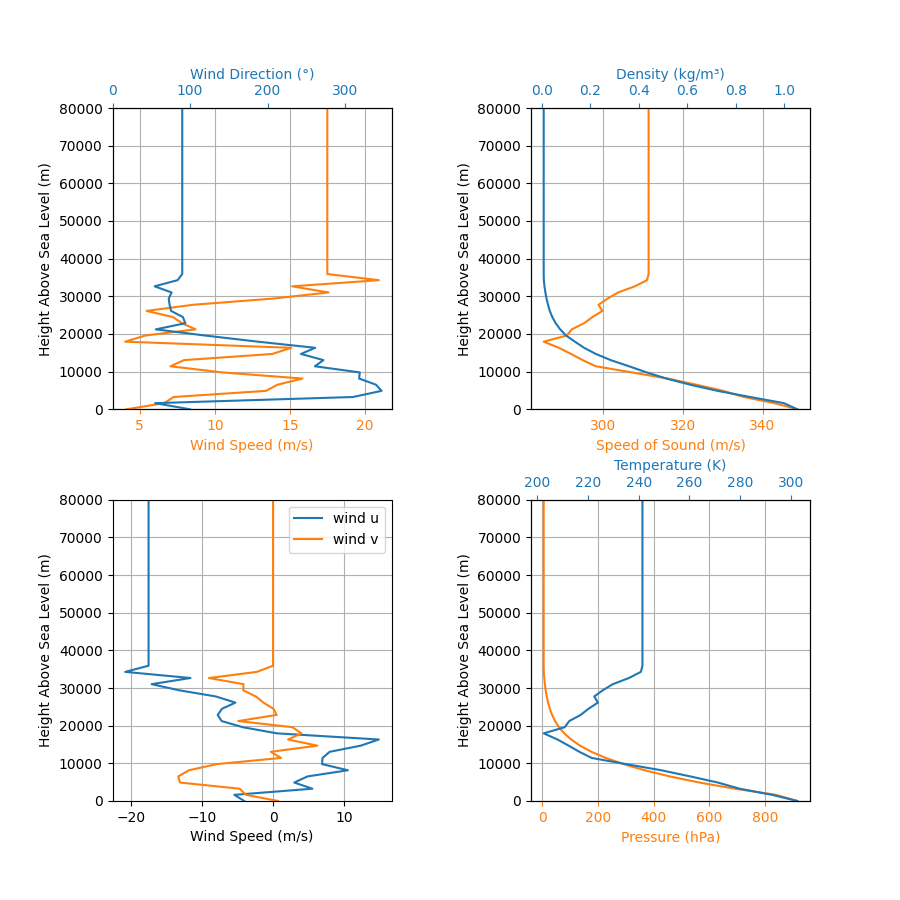

Total Impulse of the Solid Motor: 11434.020607377777 Ns


In [88]:
# Nominal Object Creation

# Env
url = "https://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2025&MONTH=06&FROM=1200&TO=1200&STNM=72265"
env = Environment()
env.set_atmospheric_model(type="wyoming_sounding", file=url)
env.plots.atmospheric_model()




# Solid Motor Definition
Kay2Motor = SolidMotor(
    thrust_source = r".\Raw Data\Andromeda\COMPMotor.eng",
    dry_mass = 0.9,
    dry_inertia = (0.475, 0.475, 0.007),
    nozzle_radius = 68.58/2000,
    grain_number = 6,
    grain_density = 1579.9,
    grain_outer_radius = 82.3 / 2000,
    grain_initial_inner_radius = 38.1 / 2000,
    grain_initial_height = 0.147955,
    grain_separation = 0,
    grains_center_of_mass_position=0.508,
    center_of_dry_mass_position=0.4826,
    nozzle_position=0,
    burn_time = 4.136,
    throat_radius = 0.01524,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

print(f"Total Impulse of the Solid Motor: {Kay2Motor.total_impulse} Ns")

# Rocket Definition
Andromeda = Rocket(
    radius = 152.4/2000,
    mass = 23.6265,
    inertia = (32.625, 32.625, 0.091),
    power_off_drag="Raw Data/Andromeda/CDPowerOff.csv",
    power_on_drag="Raw Data/Andromeda/CDPowerOn.csv",
    center_of_mass_without_motor=2.1983446,
    coordinate_system_orientation="nose_to_tail",
)
Andromeda.add_motor(Kay2Motor, position=4.1)

rail_buttons = Andromeda.set_rail_buttons(
    upper_button_position=2.794,
    lower_button_position = 4.0132,
    angular_position=0,
)

fin_set = Andromeda.add_trapezoidal_fins(
    n=4,
    root_chord=0.36195,
    tip_chord = 0.1905,
    span = 0.11684,
    position = 3700/1000,
    cant_angle = 0,
    sweep_angle = 45,
)

nose_cone = Andromeda.add_nose(
    length = 0.9144, kind="von karman", position = 0
)

Drogue = Andromeda.add_parachute(
    "Drogue", cd_s=1.00584, trigger="apogee", sampling_rate=100, lag=0
)

Main = Andromeda.add_parachute(
    "Main", cd_s=2.34696, trigger=304.8, sampling_rate=100, lag=0
)

Nominal Apogee was 4013.060449759654 m


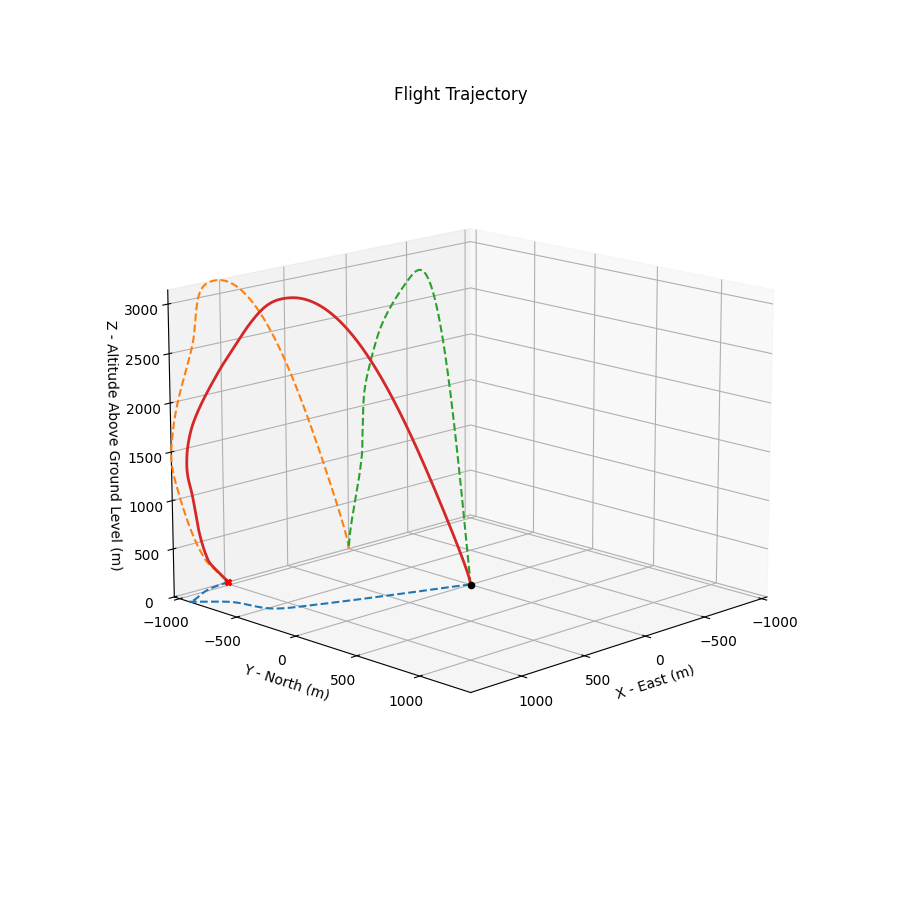

In [89]:
# Nominal Flight Simulation
test_flight = Flight(
    rocket = Andromeda, environment=env, rail_length=5.1, inclination=84.2, heading = 135)
print(f"Nominal Apogee was {test_flight.apogee} m")
test_flight.plots.trajectory_3d()

# Begin Stochastic Modeling of Rocket

In [90]:
# Stochastic Environment

stochastic_env = StochasticEnvironment(
    environment = env,
)

stochastic_env.visualize_attributes()

Reporting the attributes of the `StochasticEnvironment` object:

Constant Attributes:
	datum                    SIRGAS2000
	elevation                872.0
	gravity                  Function from R1 to R1 : (height (m)) → (gravity (m/s²))
	latitude                 0.0
	longitude                0.0
	timezone                 None

Stochastic Attributes:
	wind_velocity_x_factor   1.00000 ± 0.00000 (normal)
	wind_velocity_y_factor   1.00000 ± 0.00000 (normal)


In [91]:
# Motor
stochastic_motor = StochasticSolidMotor(
    solid_motor=Kay2Motor,
    burn_start_time = (0, 0.1, "binomial"),
    grains_center_of_mass_position=0.001,
    #grain_density = 50,
    grain_separation=1/1000,
    grain_initial_height = 1 /1000,
    throat_radius = 0.5/1000,
    nozzle_radius = 0.5/1000,
    nozzle_position=0.001,
)
stochastic_motor.visualize_attributes()

Reporting the attributes of the `StochasticSolidMotor` object:

Constant Attributes:
	burn_out_time                    4.136
	center_of_dry_mass_position      0.4826
	coordinate_system_orientation    nozzle_to_combustion_chamber
	dry_I_11                         0.475
	dry_I_12                         0
	dry_I_13                         0
	dry_I_22                         0.475
	dry_I_23                         0
	dry_I_33                         0.007
	dry_mass                         0.9
	grain_density                    1579.9
	grain_initial_inner_radius       0.01905
	grain_number                     6
	grain_outer_radius               0.04115
	interpolate                      linear
	thrust_source                    [[0, 0], [0.01, 2494.1], [0.1, 2525.584], [0.19, 2556.008], [0.28, 2585.345], [0.37, 2613.568], [0.46, 2640.65], [0.55, 2666.565], [0.64, 2691.29], [0.73, 2714.802], [0.82, 2737.08], [0.91, 2758.101], [1.0, 2777.847], [1.09, 2796.299], [1.18, 2813.44], [1.27, 2829.254]

In [100]:
# Rocket
stochastic_rocket = StochasticRocket(
    rocket = Andromeda,
    radius = 0.0127/1000,
    mass = 0.24,
    power_off_drag_factor= (1,0.1),
    power_on_drag_factor=(1,0.1),
)

# stochastic_nose_cone = StochasticNoseCone(
#     nosecone=nose_cone,
#     length = 0.001,
# )

# stochastic_fin_set = StochasticTrapezoidalFins(
#     trapezoidal_fins = fin_set,
#     root_chord = 0.0005,
#     tip_chord = 0.0005,
#     span = 0.0005,
# )

# stochastic_rail_buttons = StochasticRailButtons(
#     rail_buttons = rail_buttons, buttons_distance=0.001
# )

# stochastic_main = StochasticParachute(
#     parachute=Main,
#     cd_s=0.1,
#     lag=0.1,
# )

# stochastic_drogue = StochasticParachute(
#     parachute=Drogue,
#     cd_s=0.1,
#     lag=0.2,
# )

stochastic_rocket.add_motor(stochastic_motor, position = 0.001),
#stochastic_rocket.add_nose(stochastic_nose_cone, position = 0.001),
#stochastic_rocket.add_trapezoidal_fins(stochastic_fin_set, position=(0.001, "normal"))
#stochastic_rocket.set_rail_buttons(
#    stochastic_rail_buttons, lower_button_position=(0.001, "normal")
#)
#tochastic_rocket.add_parachute(stochastic_main)
#stochastic_rocket.add_parachute(stochastic_drogue)


stochastic_rocket.visualize_attributes()

Reporting the attributes of the `StochasticRocket` object:

Constant Attributes:
	I_11_without_motor              32.625
	I_12_without_motor              0
	I_13_without_motor              0
	I_22_without_motor              32.625
	I_23_without_motor              0
	I_33_without_motor              0.091
	center_of_mass_without_motor    2.1983446
	coordinate_system_orientation   nose_to_tail
	power_off_drag                  Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)
	power_on_drag                   Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)

Stochastic Attributes:
	mass                            23.62650 ± 0.24000 (normal)
	power_off_drag_factor           1.00000 ± 0.10000 (normal)
	power_on_drag_factor            1.00000 ± 0.10000 (normal)
	radius                          0.07620 ± 0.00001 (normal)


In [101]:
# Flight
stochastic_flight = StochasticFlight(
    flight=test_flight,
    inclination=2.5,
    heading = 10,
)
stochastic_flight.visualize_attributes()

Reporting the attributes of the `StochasticFlight` object:

Constant Attributes:
	rail_length           5.1

Stochastic Attributes:
	heading               135.00000 ± 10.00000 (normal)
	inclination           84.20000 ± 2.50000 (normal)


In [102]:
# Monte Carlo Simulation
test_dispersion = MonteCarlo(
    filename="MonteCarlo/AndromedaMC",
    environment = stochastic_env,
    rocket=stochastic_rocket,
    flight=stochastic_flight,
)

test_dispersion.simulate(
    number_of_simulations=100,
    append=False,
    include_function_data=False,
    parallel=True,
    n_workers = 10,
)

The following input file was imported: MonteCarlo\AndromedaMC.inputs.txt
A total of 100 simulations results were loaded from the following output file: MonteCarlo\AndromedaMC.outputs.txt

The following error file was imported: MonteCarlo\AndromedaMC.errors.txt                                          
Starting Monte Carlo analysis                                           
Running Monte Carlo simulation with 10 workers.


c:\Users\andyf\Documents\High Power Rocket Team\RocketPy\venv\Lib\site-packages\rocketpy\simulation\monte_carlo.py:137: UserWarning: This class is still under testing and some attributes may be changed in next versions
  warnings.warn(


Results saved to MonteCarlo\AndromedaMC.outputs.txt


In [103]:
test_dispersion.num_of_loaded_sims
test_dispersion.prints.all()

Monte Carlo Simulation by RocketPy
Data Source:  MonteCarlo\AndromedaMC
Number of simulations:  100
Results: 

                Parameter            Mean          Median       Std. Dev.    95% PI Lower    95% PI Upper
--------------------------------------------------------------------------------------------------------------
out_of_rail_stability_margin         -16.353         -16.355           0.018         -16.385         -16.317
                 x_impact         750.321         735.468         347.873         117.184        1421.997
         out_of_rail_time           0.376           0.376           0.002           0.373           0.379
     out_of_rail_velocity          27.918          27.912           0.119          27.697          28.142
              apogee_time          24.558          24.536           0.660          23.379          25.844
          max_mach_number           1.321           1.318           0.055           1.215           1.418
                  t_final        

In [104]:
from rocketpy.tools import haversine

# Launch and landing coordinates
launch_lat, launch_lon = 31.04434, -103.53517
land_lat, land_lon = 31.03553, -103.52409

# North displacement (meters)
north = haversine(launch_lat, launch_lon, land_lat, launch_lon)
if land_lat < launch_lat:
    north = -north

# East displacement (meters)
east = haversine(launch_lat, launch_lon, launch_lat, land_lon)
if land_lon < launch_lon:
    east = -east

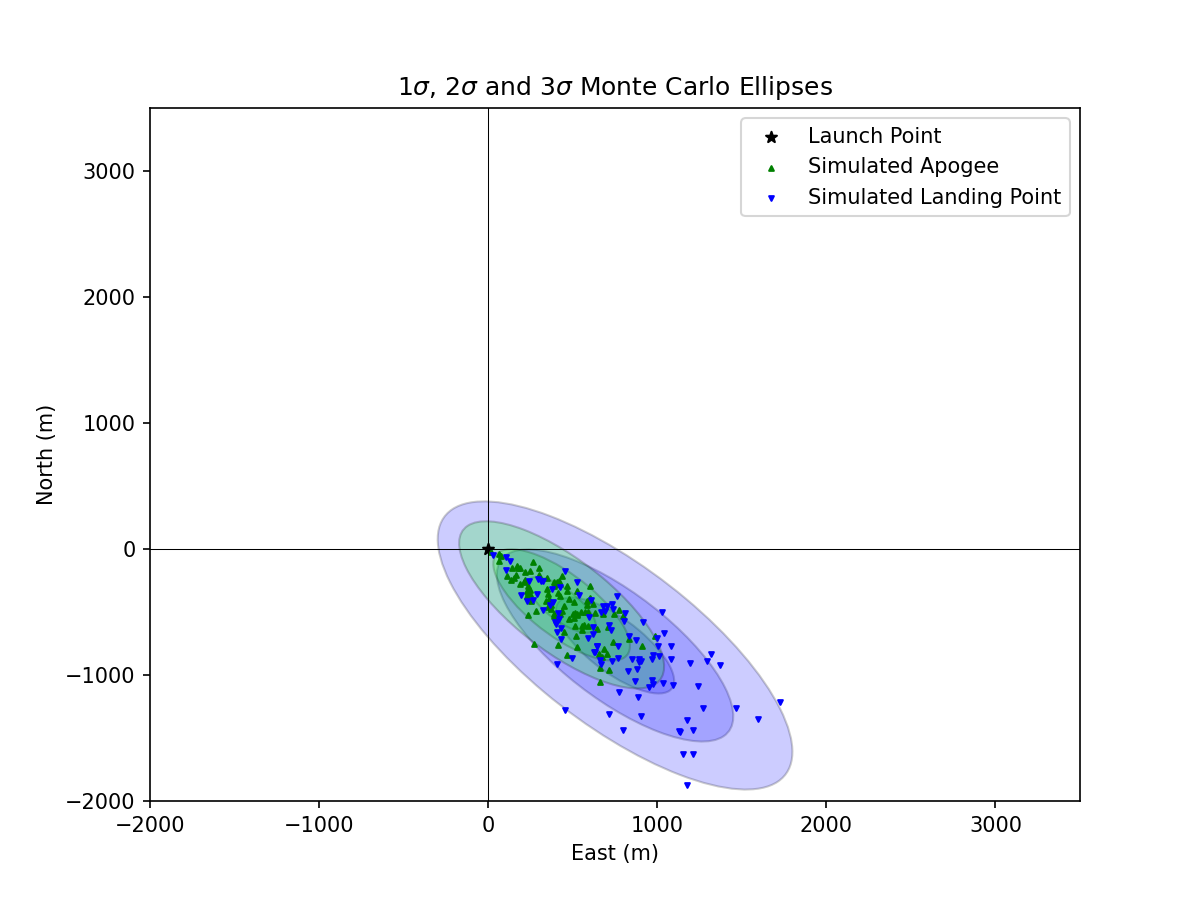

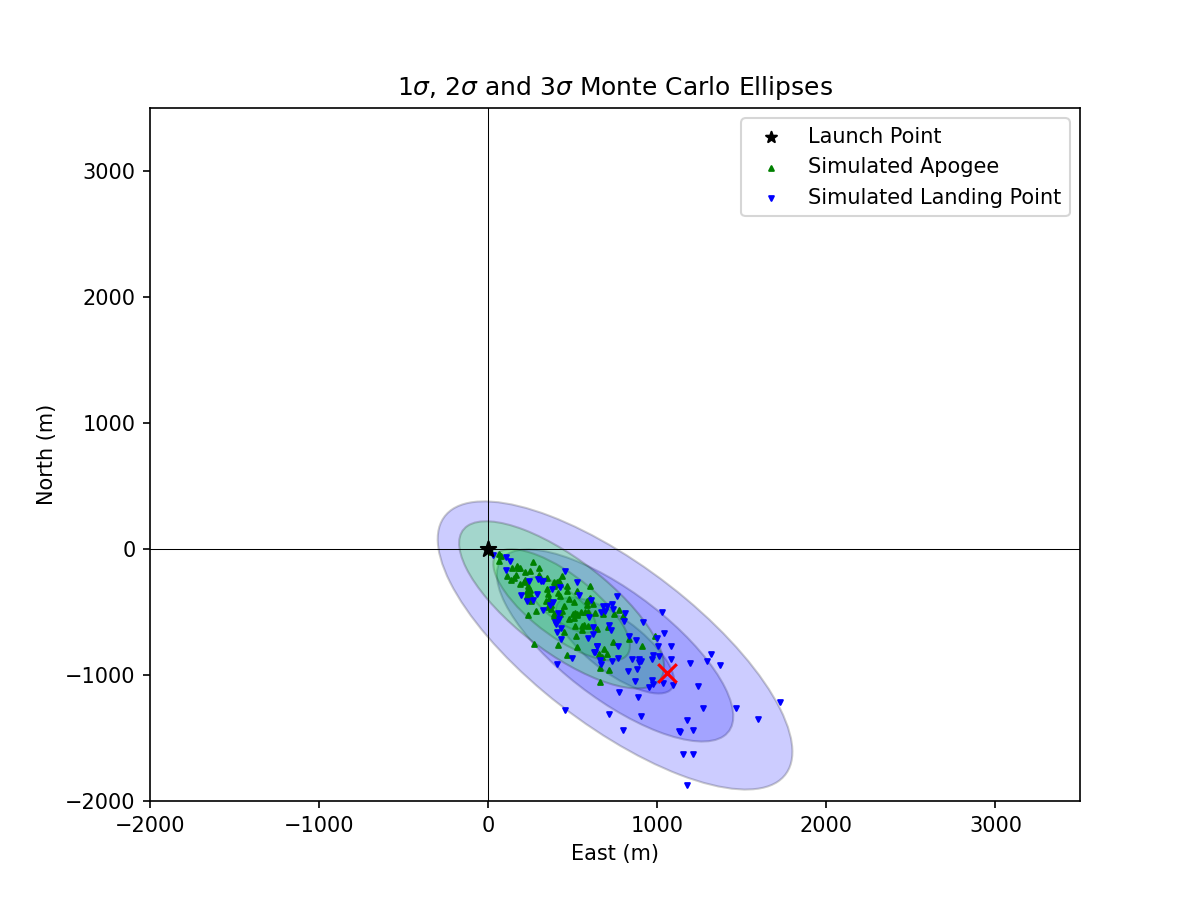

In [105]:
test_dispersion.plots.ellipses(xlim=(-2000, 3500), ylim=(-2000, 3500))

import matplotlib.pyplot as plt

# Get the current axis (must run AFTER calling .plots.ellipses)
ax = plt.gca()

# Plot the measured landing location
ax.scatter(east, north, color="red", s=80, marker="x", label="Measured Landing")
ax.scatter(0, 0, color="black", s=60, marker="*", label="Launch Site")

#ax.legend()
plt.show()